<a href="https://colab.research.google.com/github/Kulikov17/seo-optimization-product-cards/blob/main/notebooks/wb_classificator_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!unzip -q  '/content/gdrive/MyDrive/seo_data/data.zip' -d './'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

import numpy as np
import time
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm

matplotlib.style.use('ggplot')

In [8]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.

categories = os.listdir('./data')
categories.remove('.ipynb_checkpoints')

le = preprocessing.LabelEncoder()
le = le.fit(categories)

УДАЛЯЛ

In [61]:
le.inverse_transform([709])

array(['Мебель_Офисная&мебель_Перегородки&офисные'], dtype='<U83')

In [11]:
le.inverse_transform([709])

array(['Мебель_Офисная&мебель_Подставки&для&ног'], dtype='<U83')

In [9]:
df = pd.DataFrame({'class': [], 'is_card': [], 'filename': []})

In [10]:
for category in categories:
    class_num = le.transform([category])[0]
    cards = os.listdir(f'./data/{category}/card')
    feedbacks = os.listdir(f'./data/{category}/feedbacks')

    for card in cards:
      new_row = {'class': class_num, 'is_card': True, 'filename': f'./data/{category}/card/{card}'}
      df.loc[len(df)] = new_row

    for feedback in feedbacks:
      new_row = {'class': class_num, 'is_card': False, 'filename': f'./data/{category}/feedbacks/{feedback}'}
      df.loc[len(df)] = new_row

In [12]:
df

,class,is_card,filename
0,6,True,./data/Автотовары_Автокосметика&и&автохимия_Ух...
1,6,True,./data/Автотовары_Автокосметика&и&автохимия_Ух...
2,6,True,./data/Автотовары_Автокосметика&и&автохимия_Ух...
3,6,True,./data/Автотовары_Автокосметика&и&автохимия_Ух...
4,6,True,./data/Автотовары_Автокосметика&и&автохимия_Ух...
...,...,...,...
36620,125,False,./data/Детям_Детский&транспорт_Белье/feedbacks...
36621,125,False,./data/Детям_Детский&транспорт_Белье/feedbacks...
36622,125,False,./data/Детям_Детский&транспорт_Белье/feedbacks...
36623,125,False,./data/Детям_Детский&транспорт_Белье/feedbacks...


In [13]:
from sklearn.model_selection import train_test_split

X = df['filename'].to_numpy()
y = df['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [60]:
result_obj = df.groupby('class')['filename'].count()

# Теперь найдем класс, у которого count равен 1
class_with_count_one = None
for key, value in result_obj.items():
    if value == 1:
        class_with_count_one = key
        break

print(class_with_count_one)

709


In [14]:
df.groupby('class')['filename'].count()

class
0      28
1      36
2      40
3      39
4      33
       ..
947    38
948    40
949    40
950    40
951    39
Name: filename, Length: 952, dtype: int64

In [15]:
np.unique(df.groupby('class')['filename'].count())

array([ 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40])

In [16]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda', index=0)

In [19]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(25, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=8),
        transforms.ToTensor(),
        transforms.ColorJitter(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [20]:
class WildberriesDataset(Dataset):
    """Wildberries dataset."""

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        filename = self.X[idx]
        target = self.y[idx]

        if not os.path.exists(filename):
            print('No file', filename)
            pass

        img = Image.open(filename).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

In [21]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

Проверил на val, для каггла использую весь датасет

In [22]:
train_set = WildberriesDataset(X_train, y_train, transform=get_train_transform(IMAGE_SIZE))

val_set = WildberriesDataset(X_test, y_test, transform=get_valid_transform(IMAGE_SIZE))

In [23]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=True)

In [24]:
def save_model(epoch, model, optimizer, acc):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"model_epoch_{epoch}_acc{acc:.4f}.pth")

In [25]:
def training_plots(train_acc, valid_acc, train_loss, valid_loss):
    # Accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


In [26]:
def train(model, loader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [27]:
def validate(model, loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [28]:
def build_model(pretrained=True, fine_tune=True, num_classes=196):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')

    model = models.efficientnet_v2_s(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    return model

In [29]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [30]:
# Learning_parameters
lr = 1e-3
epochs = 3

In [31]:
# Load the model
model = build_model(num_classes=952).to(device)

# Total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters")

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Loss function
criterion = LabelSmoothingCrossEntropy()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',
                                                 patience=3,
                                                 threshold=0.9,
                                                 min_lr=1e-6,
                                                 verbose=True)

[INFO]: Loading pre-trained weights


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 55.5MB/s]


[INFO]: Fine-tuning all layers...
21,397,000 total parameters
21,397,000 training parameters


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[INFO]: Epoch 1 of 3
Training


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/859 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation


  0%|          | 0/287 [00:00<?, ?it/s]

Training loss: 6.472, training acc: 1.067
Validation loss: 5.945, validation acc: 3.407
--------------------------------------------------
[INFO]: Epoch 2 of 3
Training


  0%|          | 0/859 [00:00<?, ?it/s]

Validation


  0%|          | 0/287 [00:00<?, ?it/s]

Training loss: 5.663, training acc: 5.730
Validation loss: 5.414, validation acc: 7.535
--------------------------------------------------
[INFO]: Epoch 3 of 3
Training


  0%|          | 0/859 [00:00<?, ?it/s]

Validation


  0%|          | 0/287 [00:00<?, ?it/s]

Training loss: 5.020, training acc: 12.618
Validation loss: 4.956, validation acc: 14.776
--------------------------------------------------
TRAINING COMPLETE


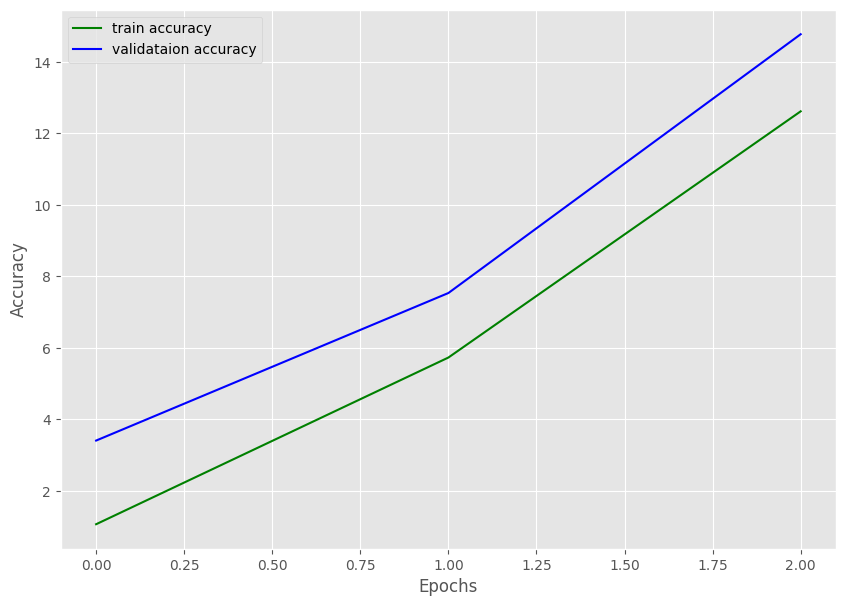

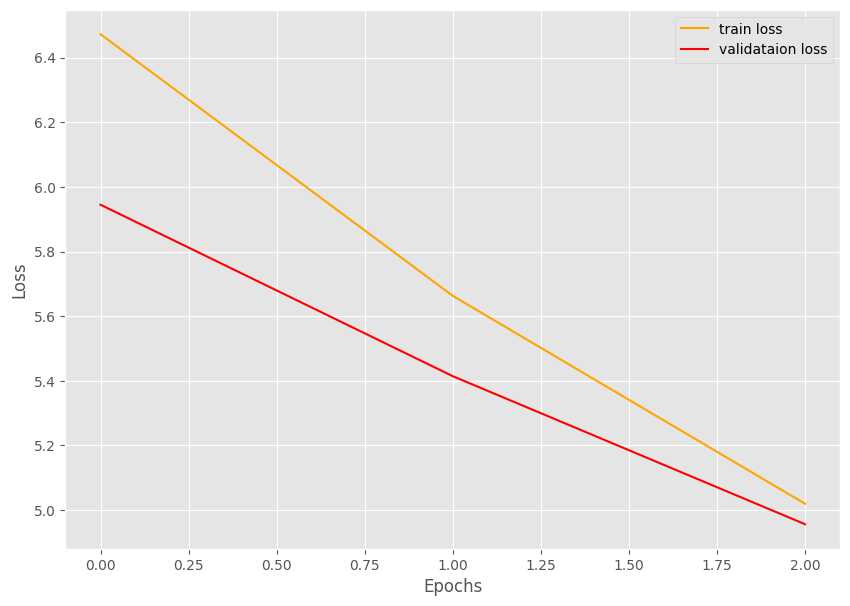

In [32]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

    if scheduler is not None:
        scheduler.step(valid_epoch_acc)

    save_model(epoch, model, optimizer, valid_epoch_acc)


# Save the loss and accuracy plots.
training_plots(train_acc, valid_acc, train_loss, valid_loss)

print('TRAINING COMPLETE')

In [ ]:
model_pth = './model_epoch_2_acc100.0000.pth'

#checkpoint = torch.load(model_pth, map_location=torch.device('cpu'))
checkpoint = torch.load(model_pth)

model = build_model(num_classes=2).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt",
                 1: "Jeans",
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
image = Image.open('./wildberries/val/jeans-2.png').convert('RGB')
tranforms = get_valid_transform(IMAGE_SIZE)
input_tensor = tranforms(image)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch)


_, predicted_class = torch.max(output, 1)

In [ ]:
output_label(predicted_class)

'Jeans'